In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+503.ga94517ccc.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory.


In [4]:
from desc.particles import *
from diffrax import *

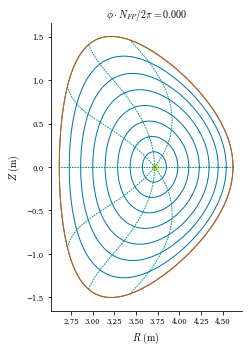

In [5]:
eq = get("DSHAPE")
plot_surfaces(eq);

In [6]:
model = VacuumGuidingCenterTrajectory(frame="flux")
rho = 0.4
N = 5
particles = ManualParticleInitializerFlux(
    rho0=[rho]*N,
    theta0=np.linspace(0, np.pi, N),
    zeta0=0,
    xi0=0.3,
    E=1e1, 
)
# particles = ManualParticleInitializerFlux(
#     rho0=[rho],
#     theta0=3*np.pi/4,
#     zeta0=0,
#     xi0=0.3,
#     E=1e1, 
# )
ts = np.linspace(0, 1e-4, 500)

In [ ]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
fig, data = plot_particle_trajectories(
    eq,
    model,
    particles,
    ts=ts,
    fig=fig,
    rtol=1e-3,
    atol=1e-3,
    return_data=True,
)
fig

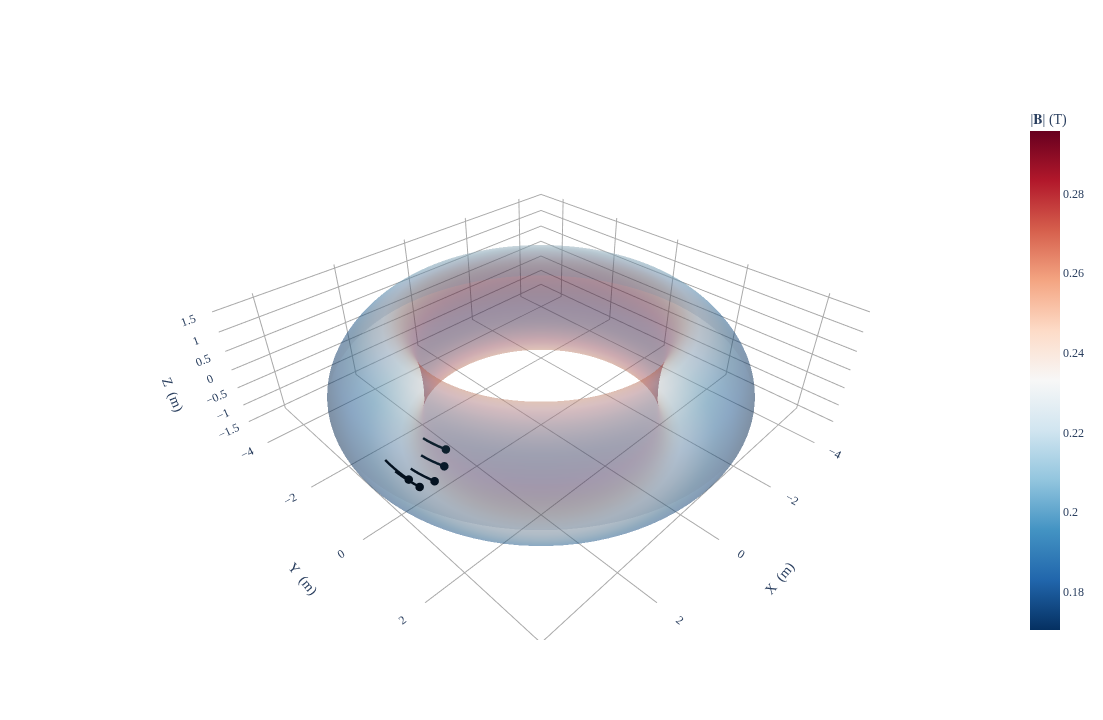

In [13]:
# 3D plots use grid NFP=1 to plot all toroidal surfaces
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(eq, "|B|", alpha=0.3)
for theta in np.linspace(0, np.pi, N):
    particles = ManualParticleInitializerFlux(
        rho0=[rho],
        theta0=theta,
        zeta0=0,
        xi0=0.3,
        E=1e1, 
    )
    fig = plot_particle_trajectories(
        eq,
        model,
        particles,
        ts=ts,
        fig=fig,
        rtol=1e-3,
        atol=1e-3,
    )
fig

In [9]:
model = VacuumGuidingCenterTrajectory(frame="flux")
rho = 0.4
N = 5
ts = np.linspace(0, 1e-4, 500)

def fun():
    for theta in np.linspace(0, np.pi, N):
        particles = ManualParticleInitializerFlux(
            rho0=[rho],
            theta0=theta,
            zeta0=0,
            xi0=0.3,
            E=1e1, 
        )
        x, v = trace_particles(
            field=eq,
            model=model,
            initializer=particles,
            ts=ts,
            rtol=1e-3,
            atol=1e-3,
        )
    return x

%timeit fun().block_until_ready();

22.2 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model = VacuumGuidingCenterTrajectory(frame="flux")
rho = 0.4
N = 5
ts = np.linspace(0, 1e-4, 500)

def fun():
    particles = ManualParticleInitializerFlux(
        rho0=[rho],
        theta0=np.linspace(0, np.pi, N),
        zeta0=0,
        xi0=0.3,
        E=1e1, 
    )
    x, v = trace_particles(
        field=eq,
        model=model,
        initializer=particles,
        ts=ts,
        rtol=1e-3,
        atol=1e-3,
    )
    return x

%timeit fun().block_until_ready();